In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt             
import pandas as pd
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from random import shuffle  
from zipfile import ZipFile
import random
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import pickle
import torch
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from PIL import Image as im
import torchvision
import torch.nn.functional as F

## Inspect the dataset 
You can find the dataset at `./../../archive/LIS-fingerspelling-dataset`.
Try to understand the shape of the data and load it in the provided `LIS_FINGERSPELLING` dataset class

<hr>

## Esamina il dataset
Puoi trovare il dataset in `./../../archive/LIS-fingerspelling-dataset`.
Cerca di capire la forma dei dati e caricali nella classe `LIS_FINGERSPELLING` fornita.

In [2]:
def generate_data(PATH=os.path.join(os.getcwd(),'archive', 'LIS-fingerspelling-dataset'), IMG_SIZE=150):
    lookup = dict()
    reverselookup = dict()
    count = 0

    for j in os.listdir(PATH):
        if j != 'readme.txt': # If running this code locally, this is to 
            # ensure you aren’t reading in hidden folders
            lookup[j] = count
            reverselookup[count] = j
            count = count + 1


    x_data = []
    y_data = []
    datacount = 0 
    for j in os.listdir(PATH):
        if j != 'readme.txt': 
            count = 0 
            for k in os.listdir(PATH+ '/'+str(j)):
                path = PATH +'/'+ str(j)+'/'+str(k)
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                img = transforms.ToTensor()(img).unsqueeze(dim=0)
                x_data.append(img) 
                count = count + 1
            y_values = torch.full((count, 1), lookup[j]) 
            y_data.extend(y_values)
            datacount = datacount + count
    x_data = torch.cat(x_data)
    y_data = torch.cat(y_data).long()

    y_data_cat = F.one_hot(y_data, num_classes=len(reverselookup.keys()))
    #x_data_res = x_data/255
    
    x_train,x_test,y_train,y_test=train_test_split(x_data,y_data_cat,test_size=0.15,random_state=1,stratify=y_data_cat)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1765, random_state=1, stratify=y_train)
    return x_train, x_val , x_test, y_train, y_val ,y_test, reverselookup



class LIS_FINGERSPELLING(Dataset):
    def __init__(self, x_data, y_data):
        self.x = x_data.float()
        self.y = y_data.float()

    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)
    
    def show_image(self, index):
        img = self.x[index]
        trans = torchvision.transforms.ToPILImage()
        img = trans(img)
        img.show()
        img.save('showing.png')
        



## Create your model class

<hr>

## Crea la classe per il tuo modello

In [3]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=22):  # Change num_classes as needed
        super(CNNModel, self).__init__()

        # Conv Layer 1: Input (1, 150, 150) -> Output (32, 148, 148) -> Pool (32, 74, 74)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv Layer 2: Output (64, 72, 72) -> Pool (64, 36, 36)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)

        # Conv Layer 3: Output (128, 34, 34) -> Pool (128, 17, 17)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128*17*17, 512)  # Flattened input size
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv2 -> ReLU -> Pool
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv3 -> ReLU -> Pool

        x = x.view(x.shape[0], -1)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))  # Fully Connected Layer 1 -> ReLU
        x = self.fc2(x)  # Output layer
        return x


## Write the training loop

<hr>

## Scrivi il ciclo di addestramento

In [4]:

def train_loop(trainloader, optimizer, model, criterion):
    model.train()
    total_loss = []
    for i, data in tqdm(enumerate(trainloader)):
        input, label = data
        optimizer.zero_grad()

        outputs = model(input)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        total_loss.append(loss.item())

    return sum(total_loss)/len(total_loss)


## Write the test loop

<hr>

## Scrivi il ciclo di test

In [5]:
def evaluate(loader,model, criterion):
    model.eval()
    total_loss = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader)):
            input, label = data

            outputs = model(input)
            loss = criterion(outputs, label)
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(label, 1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / len(labels)
            
            total_loss.append(loss.item())
    return sum(total_loss)/len(total_loss), accuracy


## Test the model

<hr>

## Testa il modello

In [6]:
def random_shuffle(array1, array2, array3):
    assert len(array1) == len(array2) == len(array3), "All arrays must have the same length"
    shuffled_indices = list(range(len(array1)))
    random.shuffle(shuffled_indices)
    shuffled_array1 = [array1[i] for i in shuffled_indices]
    shuffled_array2 = [array2[i] for i in shuffled_indices]
    shuffled_array3 = [array3[i] for i in shuffled_indices]
    return shuffled_array1, shuffled_array2, shuffled_array3



def showcase(reverselookup, model, test_loader, mode='random'):
    model.eval()
    total_images, total_labels, total_predicted = [], [], []
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        label = torch.argmax(labels, dim=1)

        total_images.extend(images)
        total_labels.extend(label)
        total_predicted.extend(predicted)
    images = torch.stack(total_images)
    labels = torch.stack(total_labels)
    predicted_labels = torch.stack(total_predicted)
        


    indices = []
    if mode == 'random':
        images, predicted_labels, labels = random_shuffle(images, predicted_labels, labels)
        indices = range(8)
    elif mode == 'wrong':
        for i in range(len(predicted_labels)):
            if predicted_labels[i] != labels[i]:
                indices.append(i)
                random.shuffle(indices)
        print(f"Wrongly predicted {len(indices)}/{len(labels)} images")
    elif mode == 'correct':
        for i in range(len(predicted_labels)):
            if predicted_labels[i] == labels[i]:
                indices.append(i)
                random.shuffle(indices)
        print(f"Correctly predicted {len(indices)}/{len(labels)} images")
    else:
        raise ValueError("Mode must be 'random' or 'wrong' or 'correct'")
    


    # Plot some test images with predictions
    plt.figure(figsize=(12, 4))
    for i in range(min(8, len(indices))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[indices[i]].cpu().numpy().squeeze(), cmap='gray')
        plt.title(f"Predicted: {reverselookup[predicted_labels[indices[i]].item()]}, True: {reverselookup[labels[indices[i]].item()]}")
        plt.axis('off')
    plt.show()

## Call the functions in order to make it work!

<hr>

## Chiama le funzioni nel giusto ordine per far funzionare il tuo programma!

----------------------------------------------------------------------
Showcasing before training


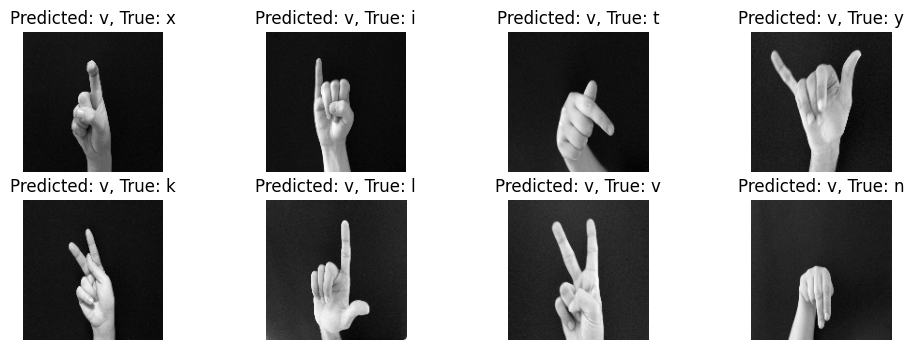

61it [00:05, 11.21it/s]


Test accuracy is  100.0 %
----------------------------------------------------------------------
Showcasing after training


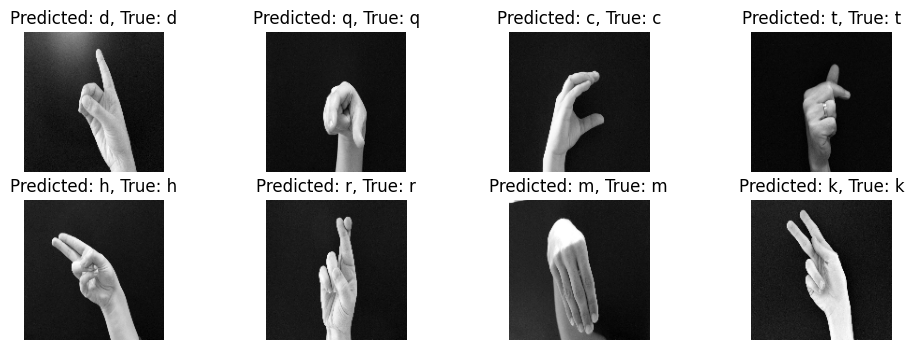

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import numpy as np # linear algebra
import matplotlib.pyplot as plt             
import pandas as pd
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from random import shuffle  
from zipfile import ZipFile
import random

from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import pickle


PATH = os.path.join(os.getcwd(),'..','..','archive', 'LIS-fingerspelling-dataset')
SAVEPATH = os.path.join(os.getcwd(), 'checkpoint','cnn','weights')
REVERSEPATH = os.path.join(os.getcwd(), 'checkpoint','cnn','reverselookup.pickle')

x_train, x_val, x_test, y_train, y_val, y_test, reverselookup = generate_data()
train_dataset = LIS_FINGERSPELLING(x_train, y_train)
val_dataset = LIS_FINGERSPELLING(x_val, y_val)
test_dataset = LIS_FINGERSPELLING(x_test, y_test)
trainloader = DataLoader(train_dataset, batch_size=128,
                        shuffle=True, num_workers=0)
valloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=16,
                        shuffle=False, num_workers=0)


with open(REVERSEPATH, 'wb') as handle:
    pickle.dump(reverselookup, handle, protocol=pickle.HIGHEST_PROTOCOL)

model = CNNModel(num_classes=len(reverselookup.keys()))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print('-'*70)
print('Showcasing before training')
showcase(reverselookup, model, testloader)

if not os.path.exists(SAVEPATH):
    epochs = 50
    
    losses = []
    best_val_loss = float('inf')
    for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
        train_loss = train_loop(trainloader, optimizer, model, criterion)
        losses.append(train_loss)
        val_loss, val_accuracy = evaluate(valloader, model, criterion)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), SAVEPATH)

    plt.plot(range(epochs), losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()
    plt.close()

else:
    model.load_state_dict(torch.load(SAVEPATH, weights_only=True))

test_loss, test_accuracy = evaluate(testloader, model, criterion)
print('Test accuracy is ', test_accuracy*100, '%')

print('-'*70)
print('Showcasing after training')
showcase(reverselookup, model, testloader)